In [1]:
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
mainpath = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS_01'
dic_cenarios = {
                # 'MPA FNS Lim Scenario 2022' : f'{mainpath}/MPV_(FNS Lim)_RC/',
                # 'V1A1F2 Scenario 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F3 Scenario 2026' :f'{mainpath}/V1A1F3_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F4 Scenario 2026' :f'{mainpath}/V1A1F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F5 Scenario 2026' :f'{mainpath}/V1A1F5_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F2 Scenario 2026 rev2' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev2_2026/',
                'V2A2F2 Scenario 2026' :f'{mainpath}/V2A2F2_REV02_2026/',
                'V2A2F3 Scenario 2026' :f'{mainpath}/V2A2F3_REV02_2026/',
                'V2A2F4 Scenario 2026' :f'{mainpath}/V2A2F4_REV02_2026/',
                'V2A2F5 Scenario 2026' :f'{mainpath}/V2A2F5_REV02_2026/',
                # 'V3A3F2 Scenario 2026 rev0' :f'{mainpath}/V3A3F2_REV0_2026/',
                # 'V3A3F3 Scenario 2026 rev0' :f'{mainpath}/V3A3F3_REV0_2026/',
                # 'V3A3F4 Scenario 2026 rev0' :f'{mainpath}/V3A3F4_REV0_2026/',
                # 'V3A3F5 Scenario 2026 rev0' :f'{mainpath}/V3A3F5_REV0_2026/',
                # 'V3A3F2 Scenario 2026 rev1' :f'{mainpath}/V3A3F2_REV1_2026/',
                # 'V3A3F3 Scenario 2026 rev1' :f'{mainpath}/V3A3F3_REV1_2026/',
                # 'V3A3F4 Scenario 2026 rev1' :f'{mainpath}/V3A3F4_REV1_2026/',
                # 'V3A3F5 Scenario 2026 rev1' :f'{mainpath}/V3A3F5_REV1_2026/',
                }

dirGeral = 'StaticAnalysis/Data/Geral/'
# dirIndice = 'StaticAnalysis/Data/Indice_n_supremo/'
dirIndice = 'StaticAnalysis/Data/Indice_n_2/'
dirRamos = 'StaticAnalysis/Data/Fluxo em Ramos/'
dirPotencia = 'StaticAnalysis/Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                (dirRamos + 'DF_HVDC.csv', 'HVDC'), 
                (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'), 
                (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                # (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'),  
                (dirPotencia+'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'), 
                (dirPotencia+'Df_Reserva_PO_MVAR.csv', 'pot_mvar_reserv'),
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
            ]

intense_palette = sns.color_palette("bright", 10)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}

# Data Processing

In [3]:
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

In [4]:
# Function to calculate indices for lines
def IndiceLinhas(df, n):

    df['MW_Flow'] = np.where(df['MW:From-To'] >= 0, df['MW:From-To'], df['MW:To-From'])
    df['PI_mva'] = (df['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt = df.groupby(
        ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    # df_r_nt['PFI'] = df_r_nt['MW_Flow'] / df_r_nt['MVA']
    df_r_nt['Mva_index'] = df_r_nt['PI_mva'] ** (1 / (2 * n))

    return df_r_nt

# Function to flatten DataFrame
def flatdf(df, BG):
    df_reordered = df.reorder_levels(['key','Dia', 'Hora', 'Cenario', 'REG', BG])
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    df_reordered = df_reordered.rename(index=regionmap, level='REG')
    df_reordered_sorted = df_reordered.sort_index(level=['key','Dia', 'Hora', 'Cenario', 'REG'])
    df_reordered_sorted.rename(columns={'CSI_INF': 'DPI_inf', 'CSI_SUP': 'DPI_sup'}, inplace=True)

    lista = [[index[0], index[1], index[2], index[3]] for index in df_reordered.index]
    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))

    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['key','Dia', 'Hora', 'Cenario']
    
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:, :, :, : ,reg, :].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                reg_name = 'SE-CO' if reg == 'Sudeste-Centro-Oeste' else reg
                columns.append(f"{column}_{reg_name}_{bg}")

    datapd.columns = columns
    return datapd

# Function to read data
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures(df_nt, df_ger, dfpq, dfpv):
    # Step 1: Merge DataFrames with only necessary columns
    dfpq_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'CSI_INF', 'CSI_SUP']
    dfpv_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'CSI_INF', 'CSI_SUP']

    datafeatures_pq = df_nt.merge(dfpq[dfpq_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')
    datafeatures_pq = datafeatures_pq[['BUS_ID', 'BUS_NAME', 'ARE', 'VBASEKV', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'B0_MVAR']]

    datafeatures_pv = df_ger.merge(dfpv[dfpv_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'], how='left')
    datafeatures_pv = datafeatures_pv[['BUS_ID', 'BUS_NAME', 'ARE', 'Gen_Type', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'PG_MW', 'QG_MVAR']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['Importance_inf'] = datafeatures_pq['IndiceInf'] / datafeatures_pq['CSI_INF'].replace(0, np.nan)
    datafeatures_pq['Importance_sup'] = datafeatures_pq['IndiceSup'] / datafeatures_pq['CSI_SUP'].replace(0, np.nan)

    datafeatures_pv['Importance_inf'] = datafeatures_pv['IndiceInf'] / datafeatures_pv['CSI_INF'].replace(0, np.nan)
    datafeatures_pv['Importance_sup'] = datafeatures_pv['IndiceSup'] / datafeatures_pv['CSI_SUP'].replace(0, np.nan)

    # Step 3: Filter rows directly without fillna
    datafeatures_pq = datafeatures_pq[datafeatures_pq['B0_MVAR'].notna() & (datafeatures_pq['B0_MVAR'] != 0)]
    datafeatures_pv = datafeatures_pv[datafeatures_pv['QG_MVAR'].notna() & (datafeatures_pv['QG_MVAR'] != 0)]

    # Optional: Fill NaN values in other columns with zero if necessary
    datafeatures_pq.fillna(0, inplace=True)
    datafeatures_pv.fillna(0, inplace=True)
    
    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    dfeatures_pv = datafeatures_pv.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'Gen_Type': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nbuses = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_inf', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_sup', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    result_inf_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_inf', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_sup', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    
    # Step 6: Filter by BUS_ID
    features_inf_pq = result_inf_pq[result_inf_pq['Importance_inf'] != 0]
    features_sup_pq = result_sup_pq[result_sup_pq['Importance_sup'] != 0]
    features_inf_pv = result_inf_pv[result_inf_pv['Importance_inf'] != 0]
    features_sup_pv = result_sup_pv[result_sup_pv['Importance_sup'] != 0]
    
    # Step 7: Pivot tables
    def pivot_table(df, values_list, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column='BUS_NAME'):
        filtered_df = df[df['BUS_ID'].isin(values_list)]
        pivot_df = filtered_df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df
    
    features_sup_pq_df = pivot_table(df_nt, features_sup_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_inf_pq_df = pivot_table(df_nt, features_inf_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_sup_pv_df = pivot_table(df_ger, features_sup_pv['BUS_ID'].to_list(), 'QG_MVAR')
    features_inf_pv_df = pivot_table(df_ger, features_inf_pv['BUS_ID'].to_list(), 'QG_MVAR')
    
    return features_sup_pq_df, features_inf_pq_df, features_sup_pv_df, features_inf_pv_df

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures_2(df_nt, df_r_nt):

    datafeatures_pq = df_nt.merge(df_r_nt, on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')[['From#', 'To#', 'From Name', 'To Name', '% L1', 'Mvar:Losses', 'Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'Mva_index']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['importance_lines'] = datafeatures_pq['% L1'] / datafeatures_pq['Mva_index'].replace(0, np.nan)
    datafeatures_pq.fillna(0, inplace=True)

    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby(['From#', 'To#']).agg({
        'importance_lines': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'From Name': 'first',
        'To Name':'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nlines = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'importance_lines', nlines)[['REG', 'VBASEKV','From#', 'To#', 'From Name', 'To Name','importance_lines']]
    result_inf_pq = result_inf_pq.set_index(['From Name', 'To Name'])
    mask = df_nt[['From Name', 'To Name']].apply(tuple, axis=1)
    filteredlines = df_nt[mask.isin(result_inf_pq.index)]

    # Step 7: Pivot tables
    def pivot_table(df, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column=['From Name', 'To Name']):
        pivot_df = df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df

    features_inf_pq_df = pivot_table(filteredlines, ['% L1', 'Mvar:Losses'])
    # features_inf_pq_df = pivot_table(filteredlines, ['MW_Flow'])
    features_inf_pq_df.columns = [' |'.join(filter(None, col)).strip() for col in features_inf_pq_df.columns]

    return  features_inf_pq_df

# Function to filter data based on non-convergent conditions
def filtarNC(df_list):
    df_filtrado = []
    for df_ in df_list:
        cenario = df_['Cenario'][0]
        bool_PWF_NConv = df_indice_grop[
            df_indice_grop['Cenario'] == cenario
        ][['Dia', 'Hora']].apply(tuple, axis=1)
        filtro = df_[['Dia', 'Hora']].apply(tuple, axis=1).isin(bool_PWF_NConv)
        df_filtrado.append(df_[filtro])
    return df_filtrado

# Function to concatenate and process data (part 1)
def concatenation_1():
    data = {}
    
    print('====== Selecting Critical Buses as features ======')
    ddffpv = pd.concat(dfs['IndexDec_PV'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'key'])
    ddffpq = pd.concat(dfs['IndexDec_PQ'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'key'])
    Df_ger = pd.concat(dfs['ger'], axis=0)
    Df_nt = pd.concat(dfs['nt'], axis=0)
    data['features_sup_pq_df'], data['features_inf_pq_df'], data['features_sup_pv_df'], data['features_inf_pv_df'] = computefeatures(Df_nt, Df_ger, ddffpq.reset_index(), ddffpv.reset_index())
    
    print('====== Selecting Critical Lines as features ======')
    data['df_linhas'] = pd.concat(dfs['linhas'], axis=0)
    data['df_linhas'] = data['df_linhas'][(data['df_linhas']['L1(MVA)']!=9999) & (data['df_linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
    dfl_r_nt = IndiceLinhas(data['df_linhas'], 2)
    data['features_lines'] = computefeatures_2(data['df_linhas'], dfl_r_nt.reset_index())

    print('====== Concatenation of Other Data ======')
    data['df_DPI'] = pd.concat([flatdf(ddffpq, 'VBASEKV'), flatdf(ddffpv, 'Gen_Type')], axis=1)
    data['df_ger_reg_concat'] = pd.concat(filtarNC(dfs['ger_reg']), axis=0)
    data['df_indice_group'] = pd.concat(dfs['Index_Modif'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    df_intercambios_01 = pd.concat(dfs['intercambios'], axis=0).rename(columns={'Intercambio AC': 'Intercambio'})
    df_hvdc_01 = pd.concat(dfs['HVDC'], axis=0).rename(columns={'Nome Elo':'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'})
    df_Indice_REG = pd.concat(dfs['Index'], axis=0).rename(columns={'level_0': 'Indice'})
    data['df_Trafo'] = pd.concat(dfs['Trafo'], axis=0).rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
    data['df_reserva'] = pd.concat(dfs['pot_mw_reserv'], axis=0).set_index(['Dia', 'Hora', 'Cenario'])

    df_intercambios_01 = df_intercambios_01.set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
    df_hvdc_01 = df_hvdc_01.set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
    data['df_indice_grop'] = df_indice_grop.set_index(['key','Dia', 'Hora', 'Cenario'])
    data['df_indice_group'] = data['df_indice_group'].set_index(['key','Dia', 'Hora', 'Cenario'])
    data['df_Indice_REG'] = df_Indice_REG.set_index(['Indice', 'key','Dia', 'Hora', 'REG', 'Cenario'])

    concatenated_HVDC = pd.concat([
        df_hvdc_01.loc[:,:, :, :, 'Elo_FOZ-IBIUNA']['MW:From-To'],
        df_hvdc_01.loc[:,:, :, :, 'Elo_PVEL-ARARQ']['MW:From-To'],
        df_hvdc_01.loc[:,:, :, :, 'Elo_XINGU-SE']['MW:From-To'],
        # df_hvdc_01.loc[:,:, :, :, 'Elo_CPVBTB-PVEL']['MW:From-To']
    ], axis=1, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])

    concatenated_FluxoAC = pd.concat([
        df_intercambios_01.loc[:,:, :, :, 'EXP_NE']['MW:From-To'],
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-N']['MW:From-To'],
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-SE']['MW:From-To'], 
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_N-S']['MW:From-To'],
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_SUL-SECO']['MW:From-To']

    ], axis=1, keys=['EXP_NE', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_N-S','Fluxo_SUL-SECO'])

    data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on=['key','Dia', 'Hora', 'Cenario'], how='left')
    return data

# Function to concatenate and process data (part 2)
def concatenation_2(data):
    print('====== Start processing (PO) ======')
    Df_ger = pd.concat(dfs['ger'], axis=0)

    Jirau = [7051, 7061]
    S_Antonio = [7050, 7062, 7064]
    G_Uhe_230_ACRO = [6888, 6892, 6891]
    Tucurui = [6419, 6420, 6422, 6424, 6425]
    B_Monte = [6729]
    Itaipu_50 = [1100]
    Itaipu_60 = [1107]
    I_Solt = [501]
    AngraI = [10]
    AngraII = [11]
    TPires = [4492]
    S_Mesa = [36]
    XINGO = [5061]
    Furnas = [16]

    DF_complete_PO = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['key','Dia', 'Hora', 'Cenario']).sum(numeric_only=True)
    DF_complete_PO = data['df_indice_group'].merge(DF_complete_PO, on=['key','Dia', 'Hora', 'Cenario'], how='left')
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']
    DF_complete_PO['DL_MW'] = DF_complete_PO['PL_MW'] - (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL'])

    Df_ger = Df_ger[Df_ger['BUS_ID'].isin(Jirau + S_Antonio + Tucurui + B_Monte + Itaipu_50 + Itaipu_60 + I_Solt + G_Uhe_230_ACRO)]
    DF_complete_PO[['Jirau_MW', 'Jirau_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Jirau)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['S_Antonio_MW', 'S_Antonio_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(S_Antonio)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Tucurui_MW', 'Tucurui_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Tucurui)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['B_Monte_MW', 'B_Monte_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(B_Monte)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Itaipu_50_MW', 'Itaipu_50_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_50)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Itaipu_60_MW', 'Itaipu_60_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_60)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['I_Solt_MW', 'I_Solt_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(I_Solt)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['G_ACRO_230_MW', 'G_ACRO_230_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(G_Uhe_230_ACRO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['AngraI_MW', 'AngraI_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(AngraI)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['AngraII_MW', 'AngraII_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(AngraII)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['TPires_MW', 'TPires_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(TPires)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['S_Mesa_MW', 'S_Mesa_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(S_Mesa)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Furnas_MW', 'Furnas_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Furnas)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()

    return DF_complete_PO

# Function to concatenate and process data (part 3)
def concatenation_3(data):
    print('====== Start processing (REG) ======')
    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia', 'Hora', 'REG', 'Cenario']).drop(columns='PG_FERV')
    
    df_linhas_500up = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440])]
    df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
    df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)

    df_Trafo_grouped_REG = data['df_Trafo'][data['df_Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])].groupby(by=['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1_Trafo': 'mean', 'Mvar:Losses_Trafo': 'sum'})
    
    DF_complete_PO_REG = df_linhas_grouped_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
    df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
    df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    Df_data_completo_reg = df_REG_Cenario_PQ[['OV DPI', 'UV DPI']].merge(df_REG_Cenario_PV, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0}, inplace=True)

    return Df_data_completo_reg

# Main code execution
if __name__ == '__main__':
    print('Reading data...')
    dfs = read_data()
    df_indice_grop = pd.concat(dfs['Index_PO'], axis=0)
    
    print('Concatenating data...')
    DATA = concatenation_1()
    
    DF_complete_PO = concatenation_2(DATA)
    Df_data_completo_reg = concatenation_3(DATA)
    
    # Renaming regions
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
                }
    
    Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')


Reading data...
Concatenating data...
====== Selecting Critical Buses as features ======


C:\Users\david\AppData\Local\Temp\ipykernel_1148\2058326295.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
C:\Users\david\AppData\Local\Temp\ipykernel_1148\2058326295.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=

====== Selecting Critical Lines as features ======


C:\Users\david\AppData\Local\Temp\ipykernel_1148\2058326295.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)


====== Concatenation of Other Data ======
====== Start processing (PO) ======
====== Start processing (REG) ======


In [5]:
DATA['features_sup_pv_df'].columns

Index(['Dia', 'Hora', 'Cenario', 'A.VERMUHE005', 'AMANDIBIO013',
       'APARE2UTE001', 'ARAX4-UFV138', 'ARIQU-SIN001', 'AUR2A-UFV034',
       'AUR2B-UFV034',
       ...
       'TERSANPCH013', 'UJSP--UTE000', 'VCONDESIN002', 'VITOR2SIN001',
       'VITORISIN001', 'VSANG1EOL038', 'VSANG2EOL038', 'VSANG3EOL037',
       'VSANGEEOL039', 'XINGO-UHE002'],
      dtype='object', name='BUS_NAME', length=105)

In [6]:
def separaFERV_Load(df, condition, Load = False ):
    if Load == False:
        dff = df.reset_index().merge(DF_complete_PO[['PG_FERV']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PG_FERV'] > condition[0]) & (dff['PG_FERV'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])
    else:
        dff = df.reset_index().merge(DF_complete_PO[['PL_MW']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PL_MW_y'] > condition[0]) & (dff['PL_MW_y'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])   
        dff = dff.drop(columns='PL_MW_y').rename(columns={'PL_MW_x':'PL_MW'})  
    return dff

def reorder_and_filter(df, cenario, region, columns):
    df = df.reorder_levels(['Dia', 'Hora', 'Cenario', 'REG'])[columns]
    if cenario == 'all':
        if region == 'all':
            df_reordered = df
        elif region == 'PO':
            df_reordered = df
        else:
            df_reordered = df.loc[:, :, :, region]
    else:
        if region == 'all':
            df_reordered = df.loc[:, :, cenario, :]
        elif region == 'PO':
            df_reordered = df.loc[:, :, cenario]
        else:
            df_reordered = df.loc[:, :, cenario, region]
    return df_reordered

def set_column_names(datapd, df_reordered_sorted, region):
    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + reg
                columns.append(str(name))
        datapd.columns = columns
    return datapd

def merge_data(datapd, df, cenario, key):
    if cenario == 'all':
        return datapd.merge(df, on=['Dia', 'Hora', 'Cenario'], how='left')
    if isinstance(cenario, list):
        return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora', 'Cenario'], how='left')
    return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora'], how='left')

def flatdataframe(df_data_completo, cenario, region, columns, ACDCflux=True, Reserva=False, IndiceGroup=False, DPI=False, InfoPO=False, PImva_reg_nt=False, PImva=False, Busfeatures = False, Vanalysis = None,Linefeatures = False):
    """
    Flattens the provided dataframe based on the specified filters and parameters.

    Parameters:
    df_data_completo (pd.DataFrame): The complete dataframe to be flattened.
    cenario (str or list): The scenario to filter by.
    region (str): The region to filter by.
    columns (list): The columns to include in the flattened dataframe.
    ACDCflux (bool): Include AC/DC flux data.
    Reserva (bool): Include reserve data.
    IndiceGroup (bool): Include index group data.
    DPI (bool): Include DPI data.
    InfoPO (bool): Include PO info.
    PImva_reg_nt (bool): Include PImva region NT data.
    PImva (bool): Include PImva data.

    Returns:
    pd.DataFrame: The flattened dataframe.
    """
    df_reordered_sorted = reorder_and_filter(df_data_completo, cenario, region, columns)

    if region == 'all' and cenario == 'all':
        lista = [[index[0], index[1], index[2]] for index in df_reordered_sorted.index]
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    datapd = set_column_names(datapd, df_reordered_sorted, region)

    if cenario == 'all':
        datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
    else:
        if isinstance(cenario, list):
            if region == 'all':
                datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['Dia', 'Hora', 'Cenario', 'REG'], inplace=True)
        else:
            datapd.index.set_names(['Dia', 'Hora'], inplace=True)

    if ACDCflux:
        datapd = merge_data(datapd, DATA['df_Inter_AC_DC'], cenario, 'AC_DC')
    if Reserva:
        datapd = merge_data(datapd, DATA['df_reserva'][[' Reserve']], cenario, 'Reserva')
    if IndiceGroup:
        datapd = merge_data(datapd, DATA['df_indice_group'], cenario, 'IndiceGroup')
    if DPI:
        datapd = merge_data(datapd, DATA['df_DPI'], cenario, 'DPI')
    # if PImva:
    #     datapd = merge_data(datapd, dfl_po[['PI_mva', 'PFI']], cenario, 'PImva')
    # if PImva_reg_nt:
    #     dff = flatdf(dfl_r_nt[['PI_mva', 'PFI']], 'VBASEKV')
    #     datapd = merge_data(datapd, dff, cenario, 'PImva_reg_nt')
    if InfoPO:
        columns = ['DL_MW', 'Jirau_MW', 'Jirau_MVAR', 'S_Antonio_MW',
       'S_Antonio_MVAR', 'Tucurui_MW', 'Tucurui_MVAR', 'B_Monte_MW', 'B_Monte_MVAR', 'Itaipu_50_MW', 'Itaipu_50_MVAR', 'Itaipu_60_MW','G_ACRO_230_MW', 'G_ACRO_230_MVAR',
       'Itaipu_60_MVAR', 'I_Solt_MW', 'I_Solt_MVAR']
        datapd = merge_data(datapd, DF_complete_PO[columns], cenario, 'InfoPO')
    if Busfeatures:
        if Vanalysis == 'OV':
            df_aux = DATA['features_sup_pv_df'].merge(DATA['features_sup_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_sup')
            # datapd = merge_data(datapd, DATA['features_sup_pv_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_sup_pq_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
        elif Vanalysis == 'UV':
            df_aux = DATA['features_inf_pv_df'].merge(DATA['features_inf_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_inf')
            # datapd = merge_data(datapd, DATA['features_inf_pv_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_inf_pq_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
    if Linefeatures:
        datapd = merge_data(datapd, DATA['features_lines'], cenario, 'features_lines').set_index(['Dia', 'Hora', 'Cenario'])

    datapd.columns = datapd.columns.astype(str)
    return datapd

# Explainability of the ML model

In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
shap.initjs()

In [122]:
RegressorML = True
shapValues = True
PipelineObject = False
XGB_Regressor = True
Trainall = True
cenario = 'all'
region = 'all'

# columns2 = ['PL_MW','PG_MW','QL_MVAR','QG_MVAR','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']
# columns2 = []
# columns2 = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV']
# columns2 = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV','PL_MW','PG_MW','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']
# columns2 = ['UV DPI_PQ', 'UV DPI_PV','PL_MW','PG_MW','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']
columns2 = ['OV DPI_PV', 'PL_MW','PG_MW','QL_MVAR','QG_MVAR','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL', 'Mvar:Losses_500down','Mvar:Losses_500up','% L1_500up','% L1_500down']
# columns2 = ['PL_MW','PG_MW','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']  #Colocar TRUE PARA ACDCflux

# insecure_indices = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 1).any(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

insecure_indices = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 0.2).any(axis=1)]
insecure_indices = insecure_indices.loc[(insecure_indices[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] <= 1).all(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

filtro = Df_data_completo_reg.index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(insecure_indices)
dfanalise = Df_data_completo_reg[filtro]

dfanalise = Df_data_completo_reg[filtro]
datapd3 = flatdataframe(dfanalise, cenario, region, columns2, ACDCflux=True, Reserva=False, DPI=False, IndiceGroup=False, InfoPO=True, PImva_reg_nt=False, PImva=False, Busfeatures=False, Vanalysis='OV', Linefeatures=False)
datapd3.shape

C:\Users\david\AppData\Local\Temp\ipykernel_1148\289438052.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]


(4960, 90)

In [123]:
if RegressorML:
    # colmns = ['PV_lower','PV_upper', 'PQ_lower', 'PQ_upper', 'PI_mva', 'PFI']
    # colmns = ['PV_lower','PV_upper', 'PQ_lower', 'PQ_upper']
    # colmns =['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE', 'Elo_CPVBTB-PVEL',
    #             'Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO']
    # colmns =['Fluxo_N-S']
    # colmns = ['OV DPI_PQ_AC-RO', 'UV DPI_PQ_AC-RO', 'OV DPI_PV_AC-RO',
    #             'UV DPI_PV_AC-RO', 'OV DPI_PQ_Northeast', 'UV DPI_PQ_Northeast',
    #             'OV DPI_PV_Northeast', 'UV DPI_PV_Northeast', 'OV DPI_PQ_North',
    #             'UV DPI_PQ_North', 'OV DPI_PV_North', 'UV DPI_PV_North',
    #             'OV DPI_PQ_SE-CW', 'UV DPI_PQ_SE-CW', 'OV DPI_PV_SE-CW',
    #             'UV DPI_PV_SE-CW', 'OV DPI_PQ_South', 'UV DPI_PQ_South',
    #             'OV DPI_PV_South', 'UV DPI_PV_South']
    
    # colmns = ['UV DPI_PQ_AC-RO','UV DPI_PV_AC-RO','UV DPI_PQ_Northeast',
    #             'UV DPI_PV_Northeast', 'UV DPI_PQ_North',  'UV DPI_PV_North',
    #             'UV DPI_PQ_SE-CW', 'UV DPI_PV_SE-CW',  'UV DPI_PQ_South', 'UV DPI_PV_South']

    # colmns = ['UV DPI_PV_AC-RO','UV DPI_PV_Northeast',
    #             'UV DPI_PV_North',
    #             'UV DPI_PV_SE-CW',  'UV DPI_PV_South']
    
    # colmns = ['UV DPI_PQ_AC-RO','UV DPI_PQ_Northeast',
    #             'UV DPI_PQ_North',
    #             'UV DPI_PQ_SE-CW',  'UV DPI_PQ_South']

    colmns = ['OV DPI_PV_AC-RO','OV DPI_PV_Northeast',
                'OV DPI_PV_North', 'OV DPI_PV_SE-CW',  'OV DPI_PV_South']

    # colmns = ['OV DPI_PQ_AC-RO','OV DPI_PQ_Northeast',
    #             'OV DPI_PQ_North',
    #             'OV DPI_PQ_SE-CW',  'OV DPI_PQ_South']
    
    columns_to_keep = datapd3.columns[~datapd3.columns.isin(colmns)]
    X = datapd3[columns_to_keep]
    Y = datapd3[colmns]

In [124]:
# Store results
shap_values_dict = {}
shap_expaliner_dict = {}
metrics_dict = {}

# Store predictions and true values for plotting
predictions = []
true_values = []

# Iterate over each output to train separate models
for i in range(Y.shape[1]):
    y = Y.iloc[:, i]
    
    if Trainall:
        X_train, y_train = X, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    numerical_features = [c for c in X_train.columns]
    num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
    mapper = DataFrameMapper(num, df_out=True)

    if XGB_Regressor:
        model = xgb.XGBRegressor(objective="reg:squarederror")
        # pipeline = Pipeline([
        #     ('preprocess', mapper),
        #     ('xgb', model)
        # ])
    # else:
    #     model = LinearRegression()
    #     pipeline = Pipeline([
    #         ('preprocess', mapper),
    #         ('reg', model)
    #     ])
    print(f'Total samples for training: {X_train.shape[0]}')
    print(f'Total features: {X_train.shape[1]}')
    print(f'Total output data: {y_train.shape}')

    # pipeline.fit(X_train, y_train)
    model.fit(X_train, y_train)
    
    if Trainall:
        y_pred = model.predict(X_train)
        # y_pred = pipeline.predict(X_train)
        Y_true = y_train
    # else:
    #     y_pred = pipeline.predict(X_test)
    #     Y_true = y_test

    mse = mean_squared_error(Y_true, y_pred)
    mae = mean_absolute_error(Y_true, y_pred)
    r2 = r2_score(Y_true, y_pred)
    rmse = np.sqrt(mse)
    print('========= GENERAL ANALYSIS =========')
    print(f"Mean Squared Error (MSE) for output {i}: {mse}")
    print(f"Mean Absolute Error (MAE) for output {i}: {mae}")
    print(f"R-squared (R^2) for output {i}: {r2}")
    print(f"Root Mean Squared Error (RMSE) for output {i}: {rmse}")

    # Save metrics
    metrics_dict[f'output_{i}'] = {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'rmse': rmse
    }

    # Save predictions and true values for plotting
    predictions.append(y_pred)
    true_values.append(Y_true)

    # SHAP values
    if shapValues:
        if Trainall:
            X_test = X_train
        if XGB_Regressor:
            # explainer = shap.Explainer(pipeline.named_steps['xgb'], X_train, algorithm="tree")
            explainer = shap.Explainer(model)
            # explainer = shap.Explainer(pipeline.predict, X_train, algorithm="permutation")
        # else:
        #     explainer = shap.Explainer(pipeline.named_steps['xgb'], X_train, algorithm="permutation")
        
        shap_values = explainer(X_train)
        shapeshap = np.shape(shap_values.values) 
        print(f'SHAP values for output {i} have shape {shapeshap}, so you have SHAP values for multiple instances ({shapeshap[0]} instances in this case) and multiple features ({shapeshap[1]} features).')
        
        # Save SHAP values
        shap_expaliner_dict[f'output_{i}'] = shap_values
        shap_values_dict[f'output_{i}'] = shap_values.values

Total samples for training: 4960
Total features: 85
Total output data: (4960,)
========= GENERAL ANALYSIS =========
Mean Squared Error (MSE) for output 0: 2.0160177734611686e-06
Mean Absolute Error (MAE) for output 0: 0.0008847968038804612
R-squared (R^2) for output 0: 0.9988235479259474
Root Mean Squared Error (RMSE) for output 0: 0.0014198654068119164
SHAP values for output 0 have shape (4960, 85), so you have SHAP values for multiple instances (4960 instances in this case) and multiple features (85 features).
Total samples for training: 4960
Total features: 85
Total output data: (4960,)
========= GENERAL ANALYSIS =========
Mean Squared Error (MSE) for output 1: 9.870444992871757e-05
Mean Absolute Error (MAE) for output 1: 0.0072717766211774235
R-squared (R^2) for output 1: 0.9981756287349158
Root Mean Squared Error (RMSE) for output 1: 0.009935011320009533
SHAP values for output 1 have shape (4960, 85), so you have SHAP values for multiple instances (4960 instances in this case) and

In [125]:
X_train.columns

Index(['PL_MW_AC-RO', 'PG_MW_AC-RO', 'QL_MVAR_AC-RO', 'QG_MVAR_AC-RO',
       'PG_UHE_AC-RO', 'PG_UTE_AC-RO', 'PG_EOL_AC-RO', 'PG_SOL_AC-RO',
       'Mvar:Losses_500down_AC-RO', 'Mvar:Losses_500up_AC-RO',
       '% L1_500up_AC-RO', '% L1_500down_AC-RO', 'PL_MW_Northeast',
       'PG_MW_Northeast', 'QL_MVAR_Northeast', 'QG_MVAR_Northeast',
       'PG_UHE_Northeast', 'PG_UTE_Northeast', 'PG_EOL_Northeast',
       'PG_SOL_Northeast', 'Mvar:Losses_500down_Northeast',
       'Mvar:Losses_500up_Northeast', '% L1_500up_Northeast',
       '% L1_500down_Northeast', 'PL_MW_North', 'PG_MW_North', 'QL_MVAR_North',
       'QG_MVAR_North', 'PG_UHE_North', 'PG_UTE_North', 'PG_EOL_North',
       'PG_SOL_North', 'Mvar:Losses_500down_North', 'Mvar:Losses_500up_North',
       '% L1_500up_North', '% L1_500down_North', 'PL_MW_SE-CW', 'PG_MW_SE-CW',
       'QL_MVAR_SE-CW', 'QG_MVAR_SE-CW', 'PG_UHE_SE-CW', 'PG_UTE_SE-CW',
       'PG_EOL_SE-CW', 'PG_SOL_SE-CW', 'Mvar:Losses_500down_SE-CW',
       'Mvar:Losses

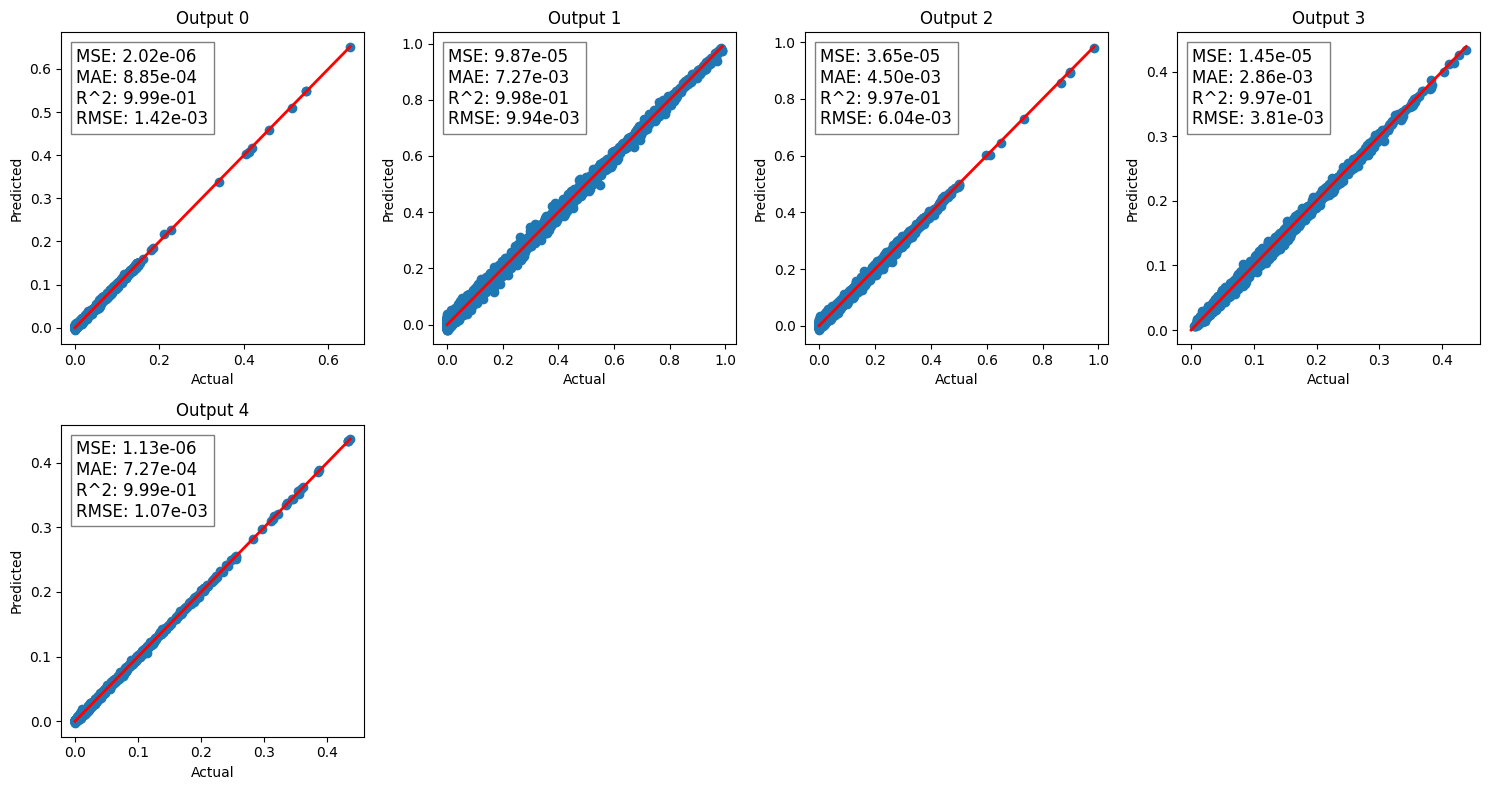

In [126]:
# Plotting
if RegressorML:
    num_plots = len(predictions)
    ncols = 4  # Number of columns for subplots
    nrows = (num_plots + ncols - 1) // ncols  # Calculate number of rows needed

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))
    axs = axs.flatten()  # Flatten in case we have a 2D array of axes

    for idx in range(num_plots):
        ax = axs[idx]
        ax.scatter(true_values[idx], predictions[idx])
        ax.plot([0, np.max(true_values[idx])], [0, np.max(true_values[idx])], color='r', linestyle='-', linewidth=2)
        ax.set_ylabel('Predicted')
        ax.set_xlabel('Actual')
        ax.set_title(f'Output {idx}')

        mse = metrics_dict[f'output_{idx}']['mse']
        mae = metrics_dict[f'output_{idx}']['mae']
        r2 = metrics_dict[f'output_{idx}']['r2']
        rmse = metrics_dict[f'output_{idx}']['rmse']

        metrics_text = f'MSE: {mse:.2e}\nMAE: {mae:.2e}\nR^2: {r2:.2e}\nRMSE: {rmse:.2e}'
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    # Remove any unused subplots
    for j in range(num_plots, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


## Shap values

output_0


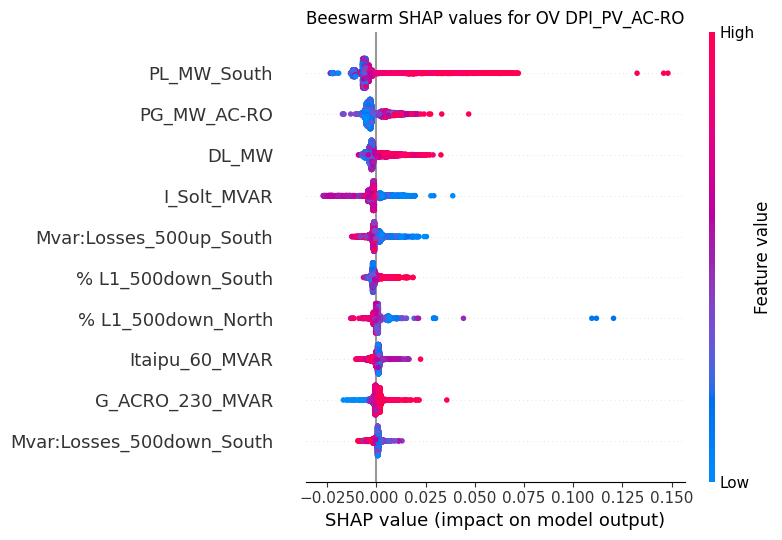

output_1


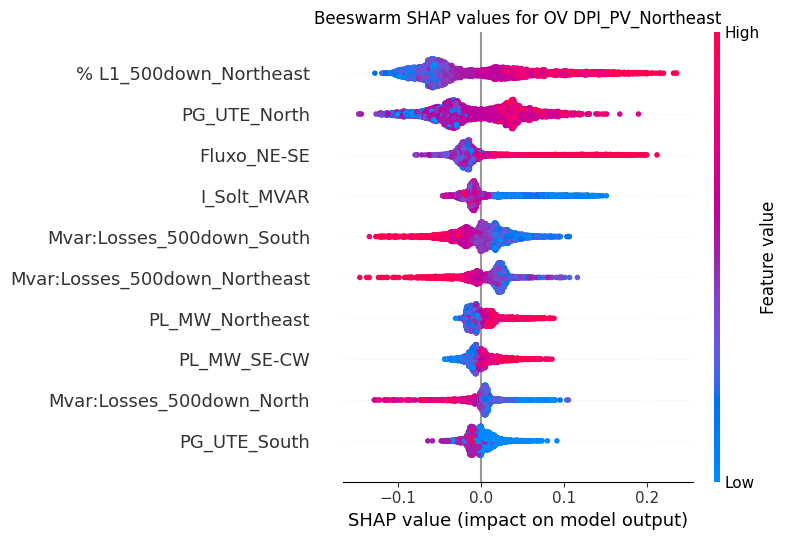

output_2


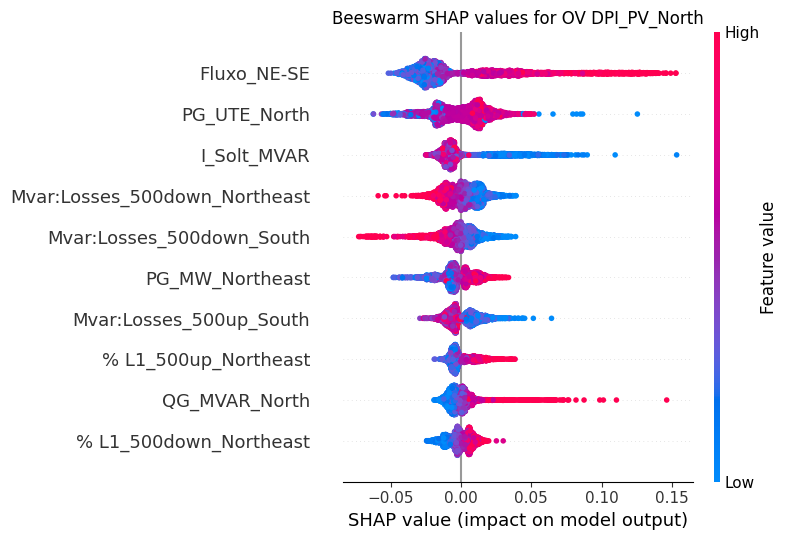

output_3


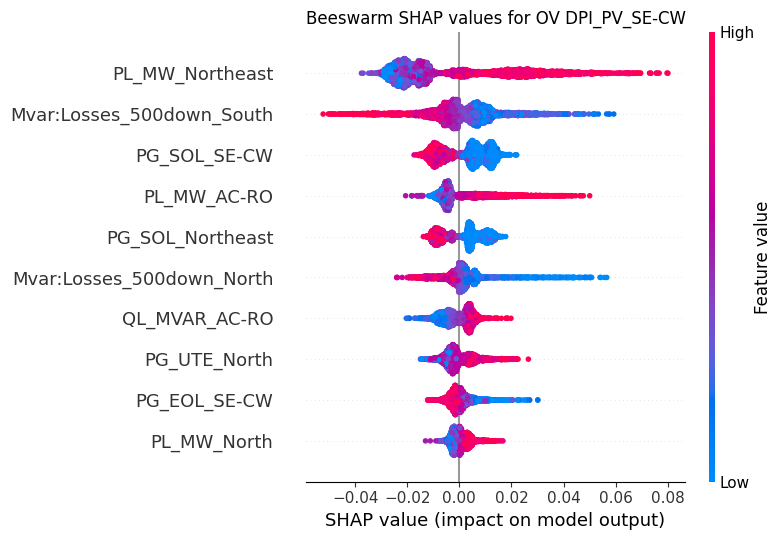

output_4


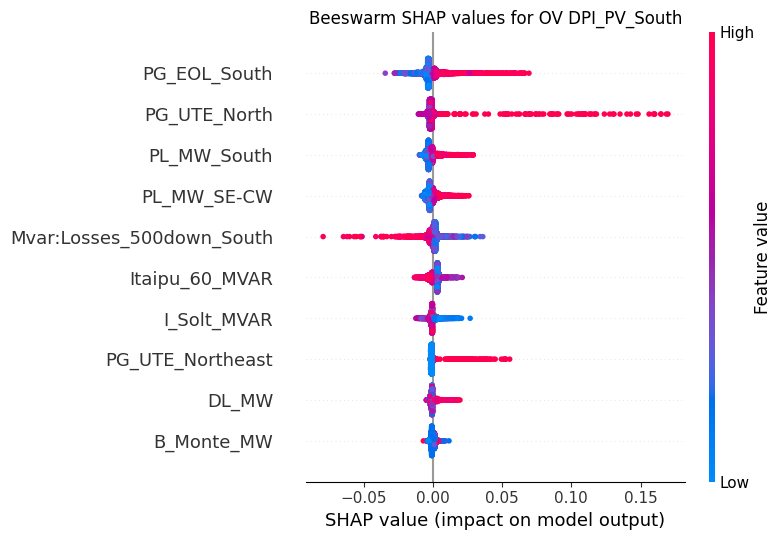

In [127]:
# SHAP summary bar and beeswarm plots
if shapValues:
    for output_key, shap_values in shap_values_dict.items():
        output_idx = int(output_key.split('_')[1])
        
        # plt.figure()
        # plt.title(f'Mean SHAP values for {Y.columns[output_idx]}')
        # shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=10)
        print(output_key)
        plt.figure()
        plt.title(f'Beeswarm SHAP values for {Y.columns[output_idx]}')
        shap.summary_plot(shap_values, X_train, max_display=10)
    

## INSECURE

In [128]:
# chosind = 'Fluxo_N-S'
# output = 'output_0'

In [129]:
# Y.reset_index()[Y.reset_index()[chosind] > 1].index

In [130]:
# shap.plots.waterfall(shap_expaliner_dict[output][737],max_display=10)

In [131]:
# true_values[0].values[Y.reset_index()[Y.reset_index()[chosind] > 1].index]

In [132]:
# predictions[0][Y.reset_index()[Y.reset_index()[chosind] > 1].index]

In [133]:
# predictions[0][284]

In [134]:
# insecure_indices = Y.reset_index()[Y.reset_index()[chosind] > 1].index
# shapvalues_insecure = shap_expaliner_dict[output][insecure_indices.values]
# shap.plots.force(shapvalues_insecure) # PV LOWER

In [135]:
# plt.figure()
# plt.title(f'Contribution of each feature in {Y.columns[int(output[-1])]}')
# # shap.plots.heatmap(shapvalues_insecure, )
# shap.plots.heatmap(shap_expaliner_dict['output_0'])

In [136]:
# ittem = insecure_indices[2]
# for output_key, shap_values in shap_expaliner_dict.items():
#     output_idx = int(output_key.split('_')[1])
#     plt.title(f'Local SHAP values for {Y.columns[output_idx]} at instance {ittem}')
#     shap.plots.waterfall(shap_values[ittem],max_display=10)

In [137]:
# X_train.columns[20:40]

In [138]:
# shap.plots.scatter(shap_expaliner_dict[output][:,27])

## DEPENDECE

OV DPI_PV_Northeast


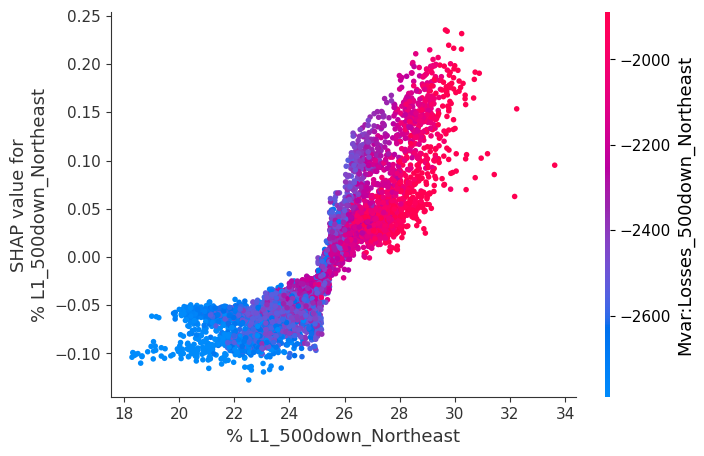

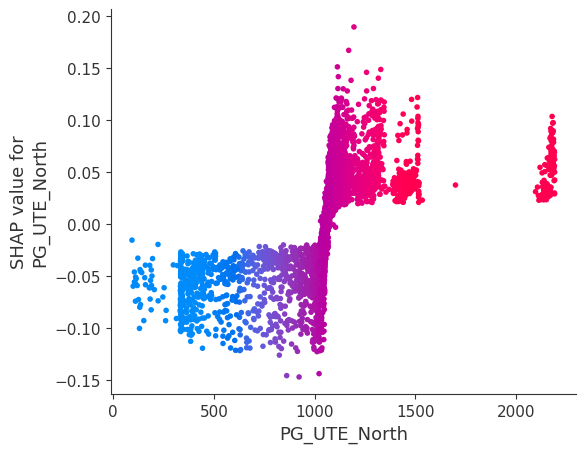

In [150]:
output = 'output_1'

print(Y.columns[int(output[-1])])
shap.dependence_plot("rank(0)", shap_expaliner_dict[output].values, X_train)
shap.dependence_plot("rank(1)", shap_expaliner_dict[output].values, X_train, interaction_index="rank(1)")

In [140]:
datapd3['Tucurui_MVAR'].min()

-922.982

In [141]:
# PWF16_Filt = DATA['df_linhas'][~(DATA['df_linhas']['REG'].isna())]
# PWF16_Filt_NEW = PWF16_Filt[(PWF16_Filt['VBASEKV'] > 138) & (PWF16_Filt['VBASEKV'] != 161)]
# grouped = PWF16_Filt_NEW.groupby(['From#', 'To#']).agg({'% L1':'mean','From Name':'first','To Name':'first','REG':'first','VBASEKV':'first'}).reset_index()
# grouped

# nbuses = 3
# def top_n_group(df, group_cols, sort_col, n):
#     return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col))
# result_inf_pq = top_n_group(grouped, ['REG','VBASEKV'], '% L1', nbuses)[['From#', 'To#', '% L1', 'From Name', 'To Name']]
# result_inf_pq